In [38]:
import numpy as np
import matplotlib.pyplot as plt
import tensortools as tt
import h5py

from scipy.stats import mannwhitneyu
import seaborn as sns
from sklearn.manifold import SpectralEmbedding

In [2]:
data_folder = 'data'
experiment = 'CC182-0906'
mat_file_path = f'{data_folder}/{experiment}/CC182_240906_Combined_dFFdotMeanValues.mat'

# Average Files:
# 4 x 36 cell (4 sessions of 10 repeats x 36 stimulus conditions)
# within each cell, we find a matrix:
# 10 repeats x 73 neurons
# where each value is the mean dF/F for each trial (presentation)

# Traces files:
# 4 x 36 cell (4 sessions of 10 repeats x 36 stimulus conditions)
# within each cell, we find a tensor:
# # frames x # neurons x # repeats (including 1 sec before and after stimulus)

In [3]:
N_REPS = 10  # Number of repetitions
N_NEURONS = 73  # Number of neurons
# N_SESSIONS = 4  # Number of sessions
# N_STIMS = 36  # Number of stimuli

with h5py.File(mat_file_path, 'r') as f:
    # Access the 'dFFdotMeanValues' dataset (which has shape 36x4)
    data = f['dFFdotMeanValues']
    
    # Check the shape of the dataset, should be (36, 4)
    N_STIMS, N_SESSIONS = data.shape
    print(f"Data shape: {data.shape}")  # Debugging statement: Expected shape (36, 4)

    X = np.zeros((N_SESSIONS*N_STIMS*N_REPS, N_NEURONS))
    
    for stim_i in range(N_STIMS):

        for session_i in range(N_SESSIONS):

            start = stim_i*N_SESSIONS*N_REPS + session_i*N_REPS
            end = stim_i*N_SESSIONS*N_REPS + (session_i+1)*N_REPS

            repetitions = f[data[stim_i, session_i]][:]
            repetitions = repetitions[:]
            repetitions = repetitions.T # Transpose to get the shape (10, 73)

            X[start:end, :] = repetitions

print(f"X shape: {X.shape}")  # Debugging statement: Expected shape (1440, 73)
stimulus_labels = np.repeat(np.arange(N_STIMS), N_SESSIONS*N_REPS)
print(f"stimulus_labels shape: {stimulus_labels.shape}")  # Debugging statement: Expected shape (1440,)
session_labels = np.repeat(np.arange(N_SESSIONS), N_STIMS*N_REPS)
print(f"session_labels shape: {session_labels.shape}")  # Debugging statement: Expected shape (1440,)

Data shape: (36, 4)
X shape: (1440, 73)
stimulus_labels shape: (1440,)
session_labels shape: (1440,)


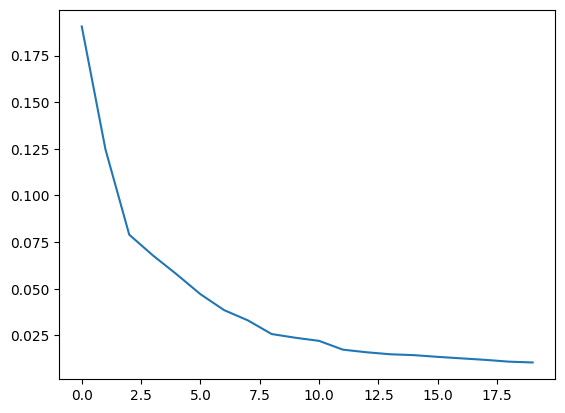

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(20)
Y = pca.fit_transform(X)
plt.plot(pca.explained_variance_ratio_)

In [5]:
gratings_ixs = [19, 6, 31, 11] #dir: 0, 90, 180, 270
neg_flows_ixs = [9, 22, 32, 0]
pos_flows_ixs = [25, 28, 2, 10]

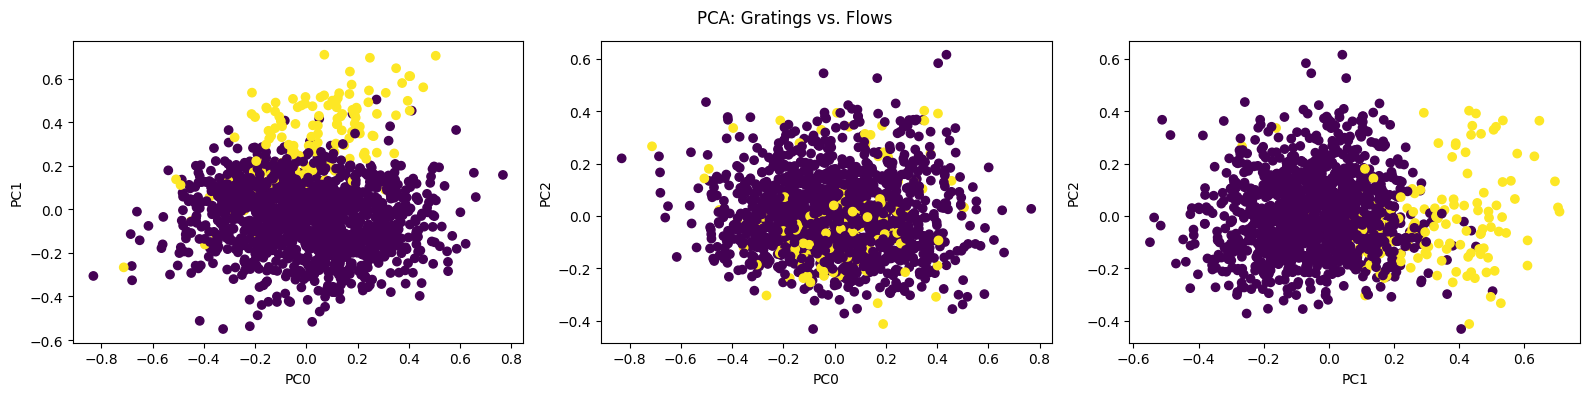

In [6]:
### GRATINGS vs. FLOWS

PCs = [(0,1), (0,2), (1,2)]

labels_to_use = stimulus_labels
gratings_vs_flows = np.zeros_like(stimulus_labels)

for i in gratings_ixs:
    gratings_vs_flows[(stimulus_labels == i)] = 1

f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    ax.scatter(*Y[:,pcs].T, c=gratings_vs_flows, cmap='viridis')
    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')
    
f.tight_layout()
plt.suptitle('PCA: Gratings vs. Flows')
plt.subplots_adjust(top=0.9)
plt.show()

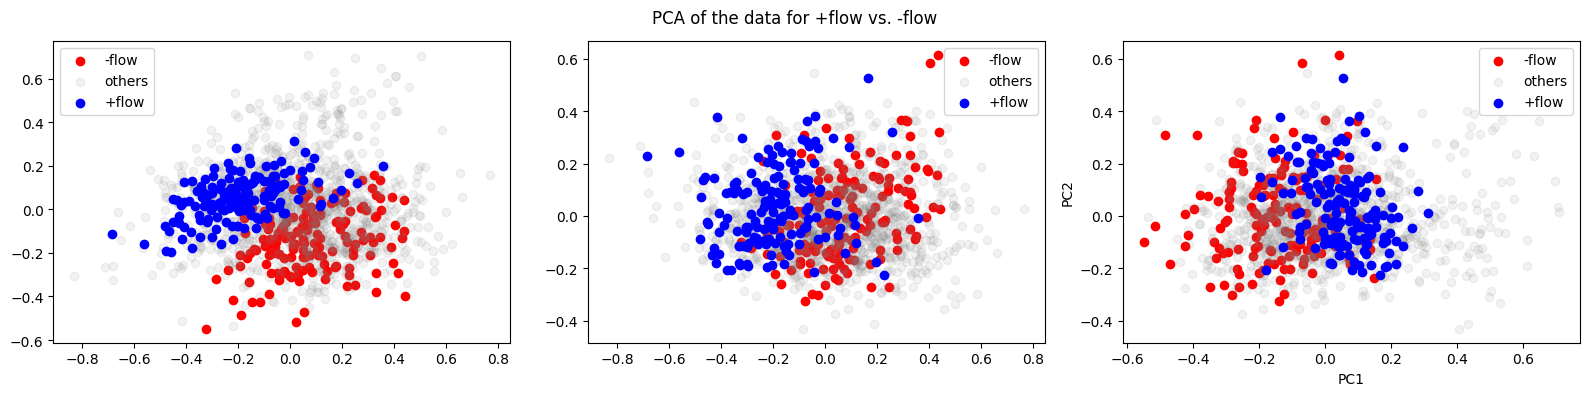

In [7]:
### +FLOW vs. -FLOWS
PCs = [(0,1), (0,2), (1,2)]

labels_to_use = stimulus_labels
pos_vs_neg_flows = np.zeros_like(stimulus_labels)

for i in neg_flows_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = -1
for i in pos_flows_ixs:
    pos_vs_neg_flows[(stimulus_labels == i)] = 1

c = pos_vs_neg_flows
colors = ['red','gray','blue']
f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    for i, (lbl, alpha, lbl_name) in enumerate([(-1, 1, '-flow'), (0, .1, 'others'), (1, 1, '+flow')]):
        ax.scatter(*Y[c==lbl][:,pcs].T, c=colors[i], alpha=alpha, label=lbl_name)
    ax.legend()
ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')
    
f.tight_layout()
plt.suptitle('PCA of the data for +flow vs. -flow')
plt.subplots_adjust(top=0.9)
plt.show()

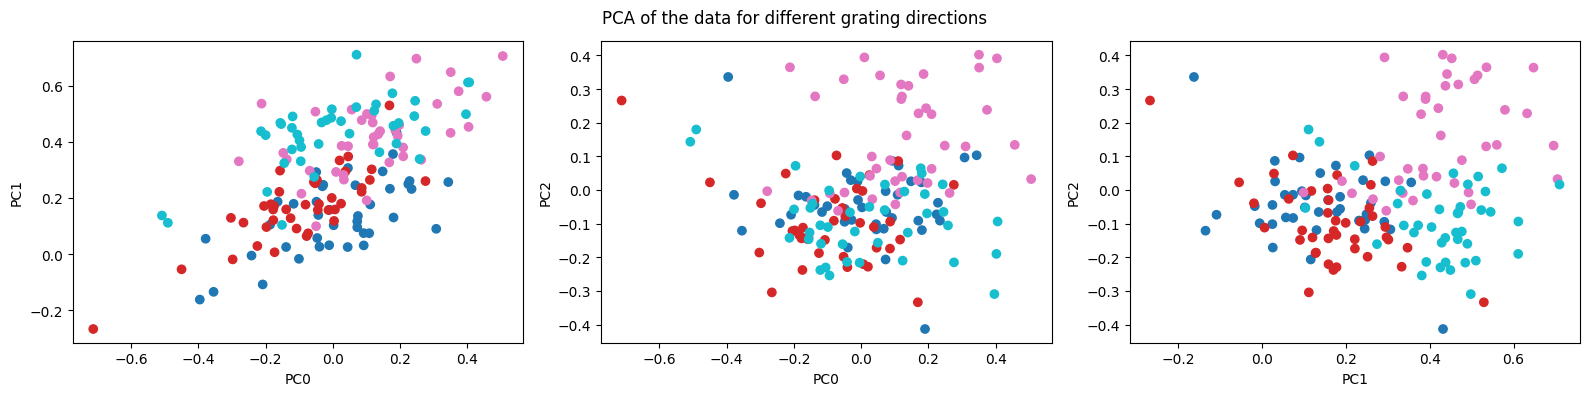

In [8]:
### GRATING DIRECTIONS

PCs = [(0,1), (0,2), (1,2)]

labels_to_use = stimulus_labels
gratings_vs_flows = np.zeros_like(stimulus_labels)
gratings_vs_flows[(stimulus_labels == 6) | (stimulus_labels == 11) | (stimulus_labels == 19) | (stimulus_labels == 31)] = 1

gratings_dirs = np.zeros_like(stimulus_labels)
gratings_dirs[(stimulus_labels == 6)] = 1
gratings_dirs[(stimulus_labels == 11)] = 2
gratings_dirs[(stimulus_labels == 19)] = 3
gratings_dirs[(stimulus_labels == 31)] = 4
gratings_dirs = gratings_dirs[gratings_vs_flows > 0]



f, axes = plt.subplots(1, len(PCs), figsize=(4*4, 4))

for ax, pcs in zip(axes, PCs):
    ax.scatter(*Y[gratings_vs_flows > 0][:,pcs].T, c=gratings_dirs, cmap='tab10')
    ax.set(xlabel=f'PC{pcs[0]}', ylabel=f'PC{pcs[1]}')
    
f.tight_layout()
plt.suptitle('PCA of the data for different grating directions')
plt.subplots_adjust(top=0.9)
plt.show()

### Encoding

In [9]:
N_NEURONS = 73
N_STIMS = 36
N_SESSIONS = 4
N_REPS = 10
TRIAL_LEN = 85

# Load the data
data_folder = 'data'

trace_file_path = f'{data_folder}/CC182-0906/CC182_240906_Combined_dFFdotTraces.mat'


with h5py.File(trace_file_path, 'r') as f:
    # Access the 'dFFdotMeanValues' dataset (which has shape 36x4)
    data = f['dFFdotTraces']
    
    # numpy_data tensor, is 36x4 which has at each cell 85x73x10
    numpy_data = np.zeros((N_STIMS, N_SESSIONS), dtype=object)
    for i in range(N_STIMS):
        for j in range(N_SESSIONS):
            temp_data = f[data[i,j]][:]
            numpy_data[i, j] = temp_data

print(f"Data shape: {numpy_data.shape}")  # Debugging statement: Expected shape (36, 4)
print(f"First tensor shape: {numpy_data[0,0].shape}")  # Debugging statement: Expected shape (85, 73, 10)


Data shape: (36, 4)
First tensor shape: (10, 73, 85)


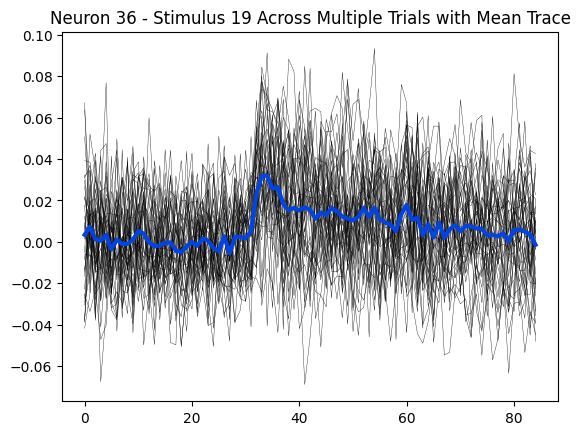

In [10]:
# plot one neuron, 1 stimulus, all trial time-courses on top of each other
# so we can have a feeling for the amount of variability
ni = 36
si = 19 # grating dir=0

all_trials_traces = np.zeros((N_SESSIONS*N_REPS, TRIAL_LEN))
for session_i in range(N_SESSIONS):
    # all_trials_traces[session_i*N_REPS:(session_i+1)*N_REPS, :] = numpy_data[si,session_i][:,ni,:] # 10 trials (10,85)
    start = session_i*N_REPS
    end = (session_i+1)*N_REPS
    all_trials_traces[start:end, :] = numpy_data[si,session_i][:,ni,:]


plt.plot(all_trials_traces.T, lw=.25, c='k');

plt.plot(all_trials_traces.mean(0), lw=3, c='xkcd:blue');
plt.title(f'Neuron {ni} - Stimulus {si} Across Multiple Trials with Mean Trace')
plt.show()

In [11]:
# Check the shape of the dataset, should be (36, 4)
N_STIMS, N_SESSIONS = data.shape
print(f"Data shape: {data.shape}")  # Debugging statement: Expected shape (36, 4)

X = np.zeros((N_NEURONS, N_STIMS, TRIAL_LEN))
for stim_i in range(N_STIMS):
    for session_i in range(N_SESSIONS):
        X[:, stim_i, :] = numpy_data[stim_i, session_i].mean(axis=0)

print(f"X shape: {X.shape}")  # Debugging statement: Expected shape (73, 36, 85)

# 36 x 4 cell (stimuli x sessions)
# where each cell is a tensor of shape 10x73x85 (trials x neurons x time)

Data shape: (36, 4)
X shape: (73, 36, 85)


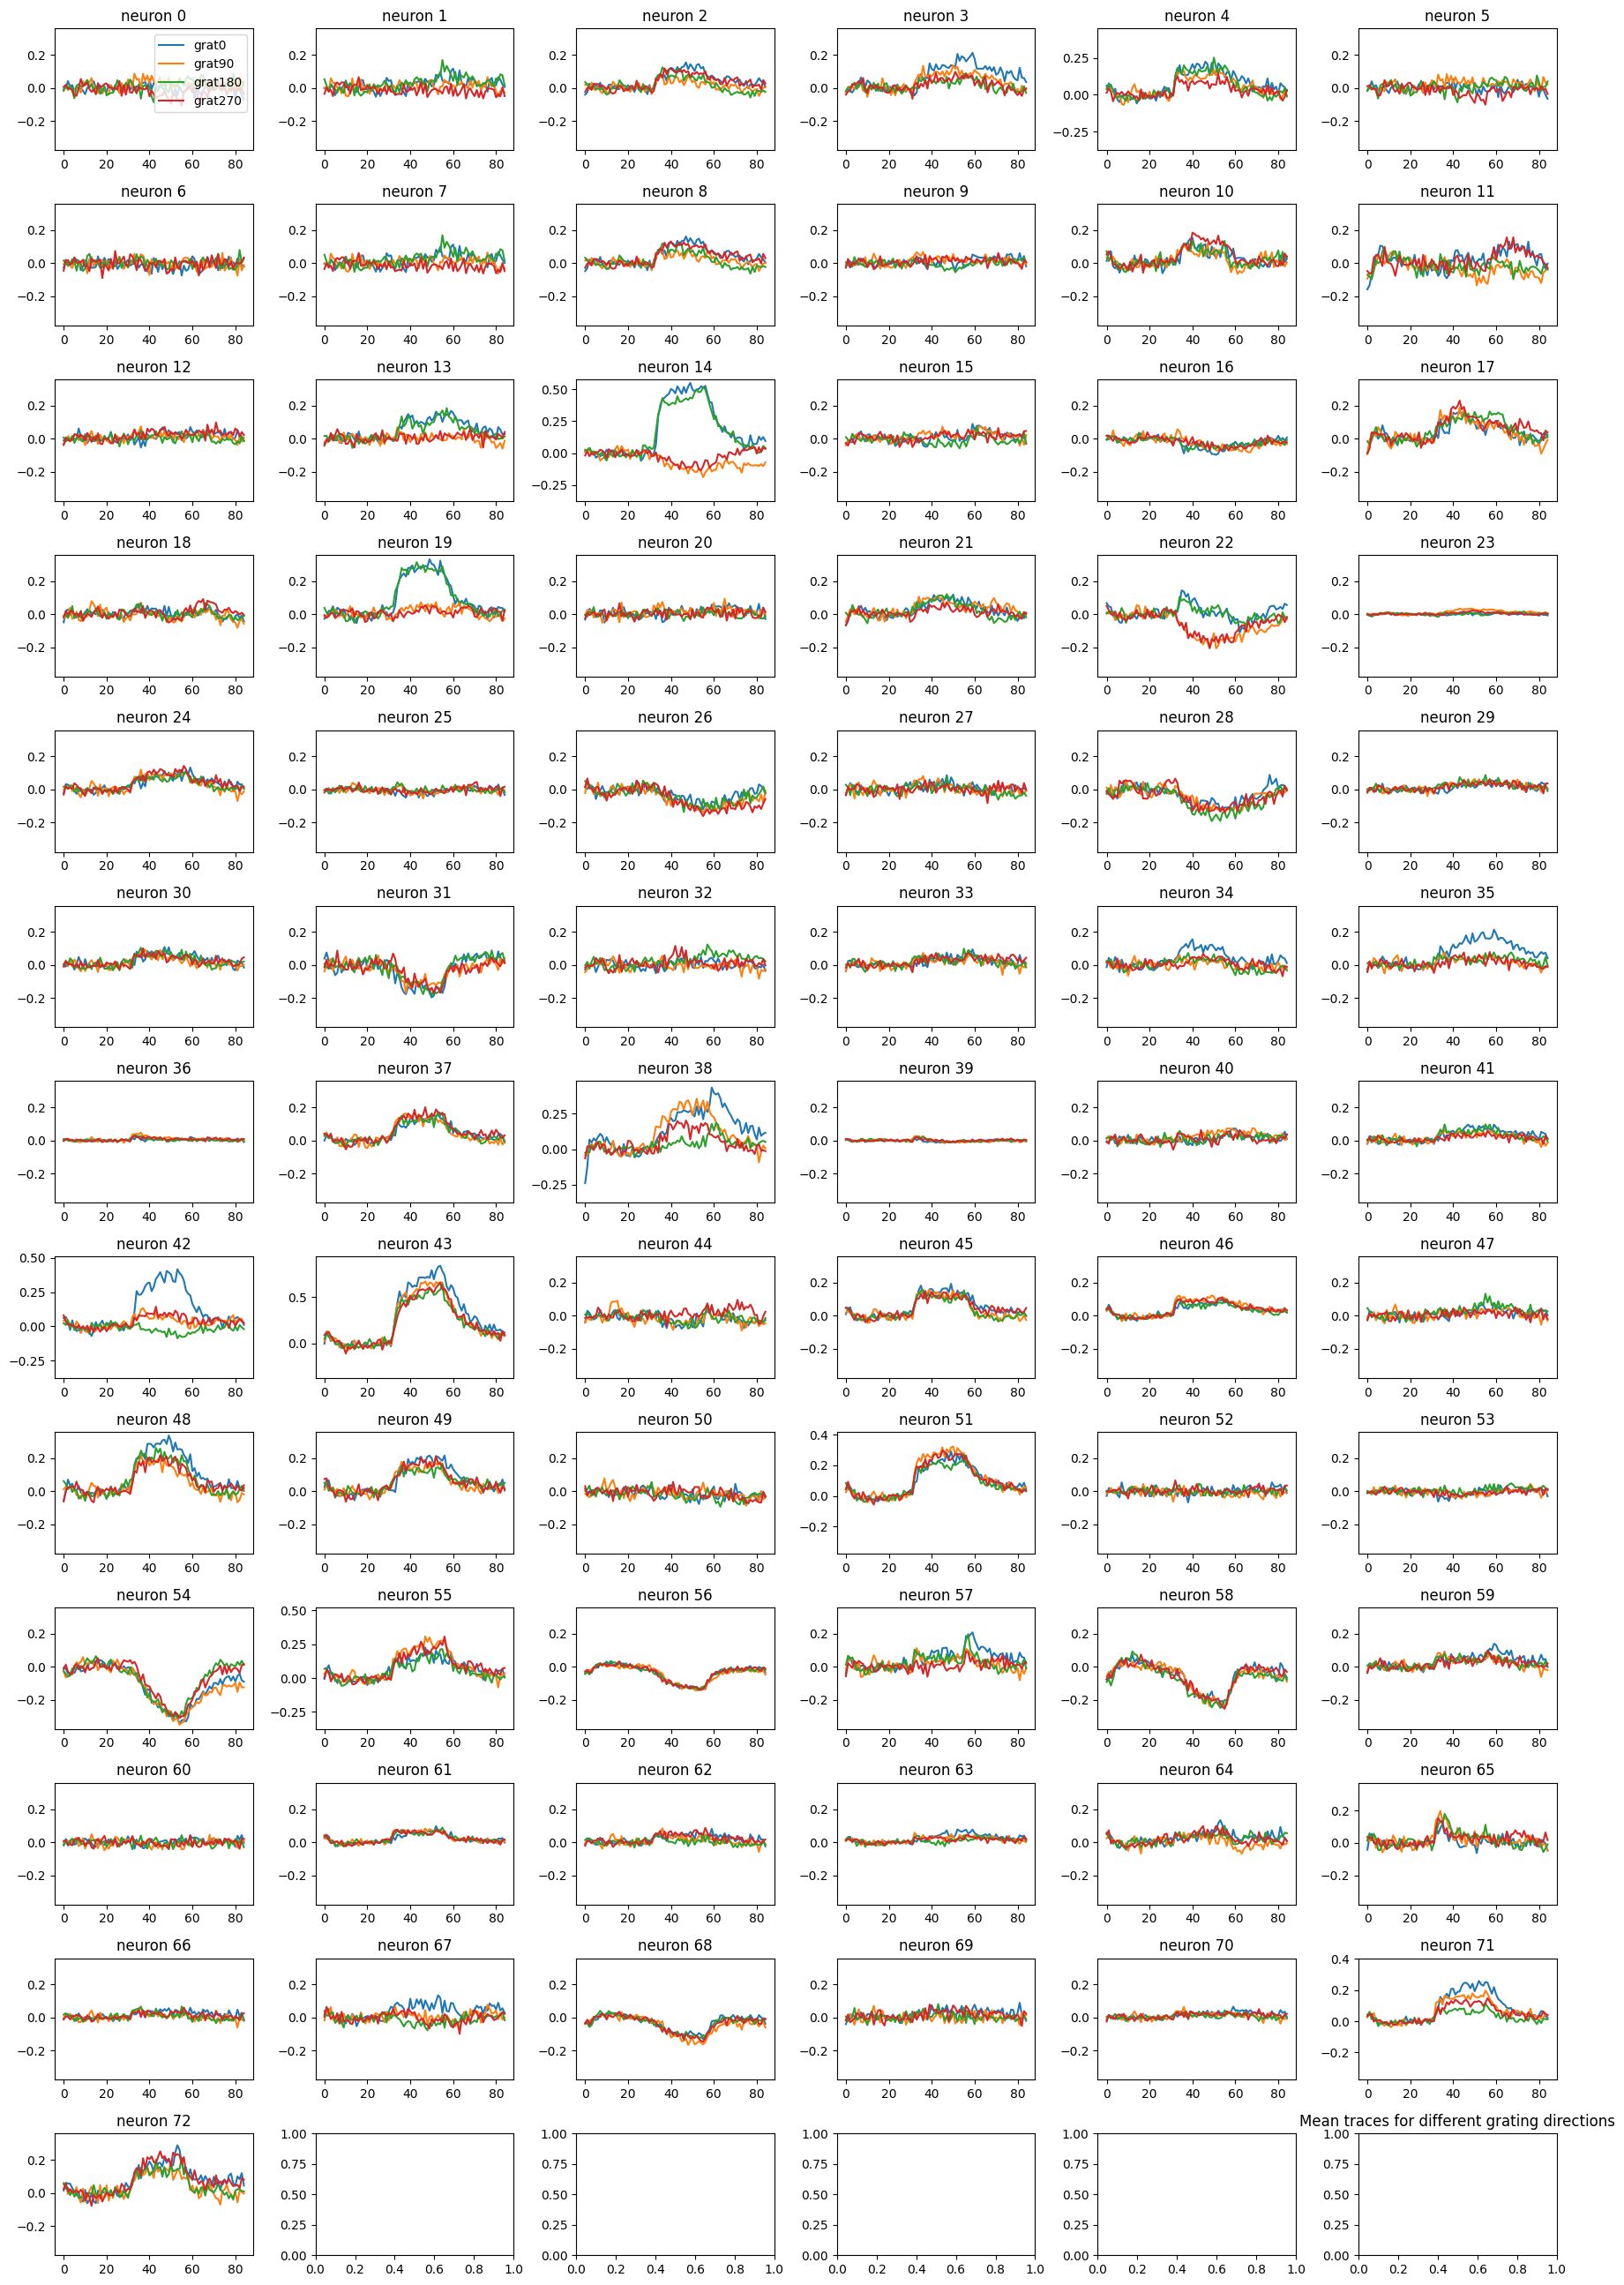

In [12]:
#pick a neuron
ni = 2

# pick some stimuli -- gratings all directions
stim_is = gratings_ixs
stim_lbls = ['grat0', 'grat90', 'grat180', 'grat270']
# f, axes = plt.subplots(1, len(stim_is), figsize=(4*len(stim_is), 3))
# for ax, si in zip(axes, stim_is):

ncols = 6
nrows = int(np.ceil(N_NEURONS/ncols))

vmin = X.min()
vmax = abs(vmin)

f, axes = plt.subplots(nrows,ncols,figsize=(ncols*3,nrows*2))
for ni in range(N_NEURONS):
    ax = axes.ravel()[ni]
    for i,si in enumerate(stim_is):
        ax.plot(X[ni, si], label=stim_lbls[i])
    ax.set(ylim=(vmin*1.05, max(vmax, X[ni].max()*1.05)), title=f'neuron {ni}')
    if ni == 0:
        ax.legend()
        
f.tight_layout()
plt.title('Mean traces for different grating directions')
plt.show()

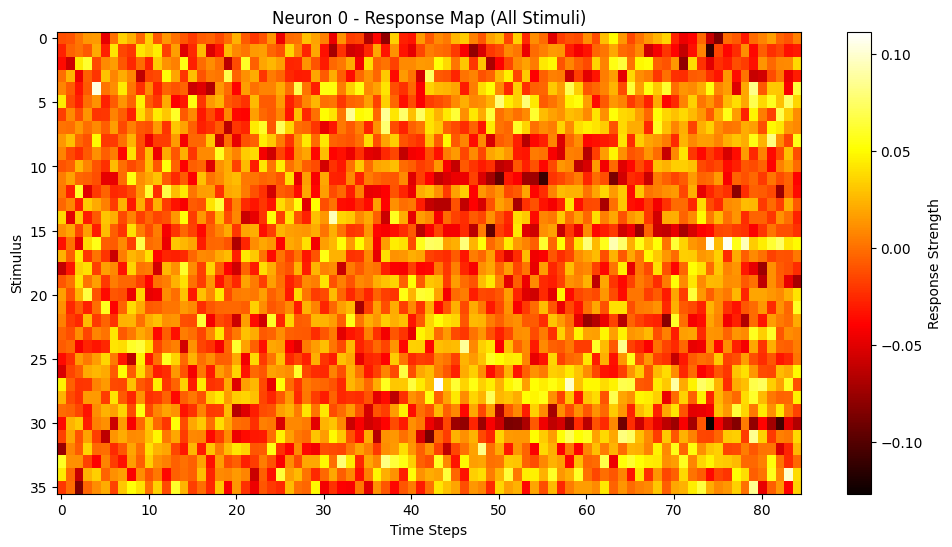

In [13]:
def plot_response_map(data_tensor, neuron_idx):
    """Plots the response map (heatmap) for a given neuron across all stimuli."""
    
    responses = data_tensor[neuron_idx]  # Shape (36, 85), all stimuli for a neuron
    
    fig, ax = plt.subplots(figsize=(12, 6))
    cax = ax.imshow(responses, aspect='auto', cmap='hot')
    ax.set_title(f'Neuron {neuron_idx} - Response Map (All Stimuli)')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Stimulus')
    
    fig.colorbar(cax, ax=ax, label='Response Strength')
    
    plt.show()

# Example: Plotting the response map for neuron 0
plot_response_map(X, neuron_idx=0)

### Statistically-Conditioned Normalization

In [14]:
# Dimensions of the data tensor - (neurons, stimuli, sessionNum, time steps)
all_nuerons_stimuli_traces = np.zeros((N_NEURONS, N_STIMS, N_SESSIONS*N_REPS, TRIAL_LEN))
for ni in range(N_NEURONS):
    for si in range(N_STIMS):
        for session_i in range(N_SESSIONS):
            start = session_i*N_REPS
            end = (session_i+1)*N_REPS
            all_nuerons_stimuli_traces[ni, si, start:end, :] = numpy_data[si,session_i][:,ni,:]

(40, 85)


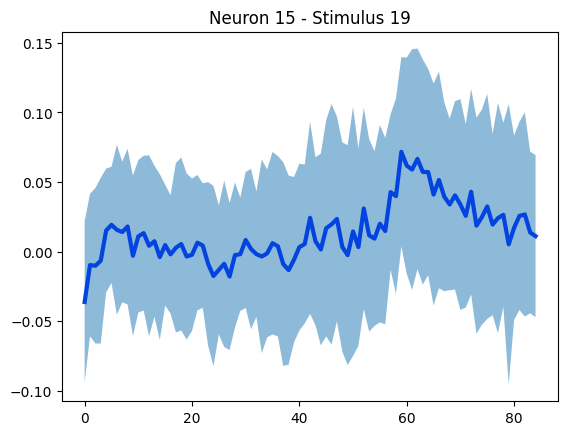

In [15]:
ni = 15 # neuron 15 of 73 (indexed 0 to 72)
si = 19 # stimulus 19 of 36 (indexed 0 to 35)
# reps (40 total) goes from 0 to 39
# time (85 total) goes from 0 to 84

# Dimensions of the data tensor - (neurons, stimuli, reps, time steps)
# all_nuerons_stimuli_traces - ((N_NEURONS, N_STIMS, N_SESSIONS*N_REPS, TRIAL_LEN))

all_trials_traces = all_nuerons_stimuli_traces[ni, si]
print(all_trials_traces.shape)

plt.plot(all_trials_traces.mean(0), lw=3, c='xkcd:blue');

# at each time point, I want to compute the standard deviation of the responses
std_responses = all_trials_traces.std(0)
plt.fill_between(range(TRIAL_LEN), all_trials_traces.mean(0)-std_responses, all_trials_traces.mean(0)+std_responses, alpha=.5)

plt.title(f'Neuron {ni} - Stimulus {si}')
plt.show()

In [16]:
N_NEURONS = 73        # Number of neurons
N_STIMS = 36          # Number of stimuli
N_REPS = 40           # Number of repetitions (trials)
TRIAL_LEN = 85        # Number of time steps per trial

# For Mann-Whitney
BASELINE_START = 0     # Start index for baseline (0-based)
BASELINE_END = 20      # End index for baseline (exclusive)
STIMULUS_START = 20    # Start index for stimulus
STIMULUS_WINDOW_SIZE = 10  # Number of time steps to consider for stimulus

P_VALUE_THRESHOLD = 0.005

EPSILON_VALUES = range(1, 11)  # E.g., epsilon from 1 to 10

In [17]:
significant_mann_whitney = []
significant_se_diff_dict = {epsilon: [] for epsilon in EPSILON_VALUES}

In [18]:
# Mann-Whitney U Test
for ni in range(N_NEURONS):
    for si in range(N_STIMS):
        all_trials_traces = all_nuerons_stimuli_traces[ni, si]  # Shape: (N_REPS, TRIAL_LEN)
        
        baseline_means = all_trials_traces[:, BASELINE_START:BASELINE_END].mean(axis=1)
        stimulus_means = all_trials_traces[:, STIMULUS_START:STIMULUS_START + STIMULUS_WINDOW_SIZE].mean(axis=1)
        
        stat, p_value = mannwhitneyu(stimulus_means, baseline_means, alternative='two-sided')
        
        # Check significance
        if p_value < P_VALUE_THRESHOLD:
            significant_mann_whitney.append((ni, si))

In [19]:
# Standard Error Difference Thresholding
for epsilon in EPSILON_VALUES:
    for ni in range(N_NEURONS):
        for si in range(N_STIMS):
            all_trials_traces = all_nuerons_stimuli_traces[ni, si]  # Shape: (N_REPS, TRIAL_LEN)
            
            mean_trace = all_trials_traces.mean(0)
            std_trace = all_trials_traces.std(0)

            # we want to know if there exists a time point where mean + std at time point t is greater than mean - std at time point t+epsilon and vice versa
            # algorithmically do this by, for each epsilon, sliding a window of size epsilon over the time points and checking if the condition is met
            for t in range(TRIAL_LEN - epsilon):

                mean_current = mean_trace[t]
                se_current = std_trace[t]
                mean_shifted = mean_trace[t + epsilon]
                se_shifted = std_trace[t + epsilon]
                
                condition1 = (mean_current + se_current) < (mean_shifted - se_shifted)
                
                condition2 = (mean_shifted + se_shifted) < (mean_current - se_current)
                
                # Combine conditions to identify non-overlapping error bars
                non_overlapping = condition1 | condition2
                
                # Check if any non-overlapping condition exists
                if np.any(non_overlapping):
                    significant_se_diff_dict[epsilon].append((ni, si))
                    significant = True
                    break  

In [20]:
# Convert lists to sets for easy operations
set_mw = set(significant_mann_whitney)

# Display Counts
print(f"Total significant (neuron, stimulus) pairs using Mann-Whitney U Test: {len(set_mw)}")
for epsilon in EPSILON_VALUES:
    count = len(significant_se_diff_dict[epsilon])
    print(f"Total significant (neuron, stimulus) pairs using SE Difference Thresholding with epsilon={epsilon}: {count}")

Total significant (neuron, stimulus) pairs using Mann-Whitney U Test: 506
Total significant (neuron, stimulus) pairs using SE Difference Thresholding with epsilon=1: 3
Total significant (neuron, stimulus) pairs using SE Difference Thresholding with epsilon=2: 106
Total significant (neuron, stimulus) pairs using SE Difference Thresholding with epsilon=3: 223
Total significant (neuron, stimulus) pairs using SE Difference Thresholding with epsilon=4: 296
Total significant (neuron, stimulus) pairs using SE Difference Thresholding with epsilon=5: 354
Total significant (neuron, stimulus) pairs using SE Difference Thresholding with epsilon=6: 408
Total significant (neuron, stimulus) pairs using SE Difference Thresholding with epsilon=7: 438
Total significant (neuron, stimulus) pairs using SE Difference Thresholding with epsilon=8: 460
Total significant (neuron, stimulus) pairs using SE Difference Thresholding with epsilon=9: 494
Total significant (neuron, stimulus) pairs using SE Difference T

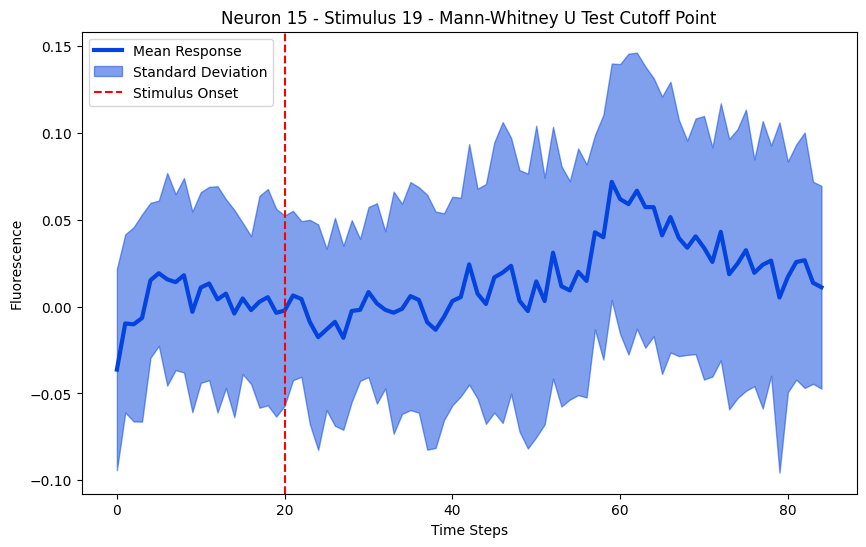

In [21]:
# Example neuron and stimulus for visualization
example_neuron = 15  # Index 15
example_stimulus = 19  # Index 19

# Extract all trials for the example neuron and stimulus
example_trials = all_nuerons_stimuli_traces[example_neuron, example_stimulus]  # Shape: (40, 85)

# Compute mean and standard error across trials
mean_response = example_trials.mean(axis=0)
std_error = example_trials.std(axis=0)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mean_response, lw=3, color='xkcd:blue', label='Mean Response')
plt.fill_between(range(TRIAL_LEN), mean_response - std_error, mean_response + std_error, 
                 color='xkcd:blue', alpha=0.5, label='Standard Deviation')
plt.axvline(x=STIMULUS_START, color='r', linestyle='--', label='Stimulus Onset')
plt.title(f'Neuron {example_neuron} - Stimulus {example_stimulus} - Mann-Whitney U Test Cutoff Point')
plt.xlabel('Time Steps')
plt.ylabel('Fluorescence')
plt.legend()
plt.show()

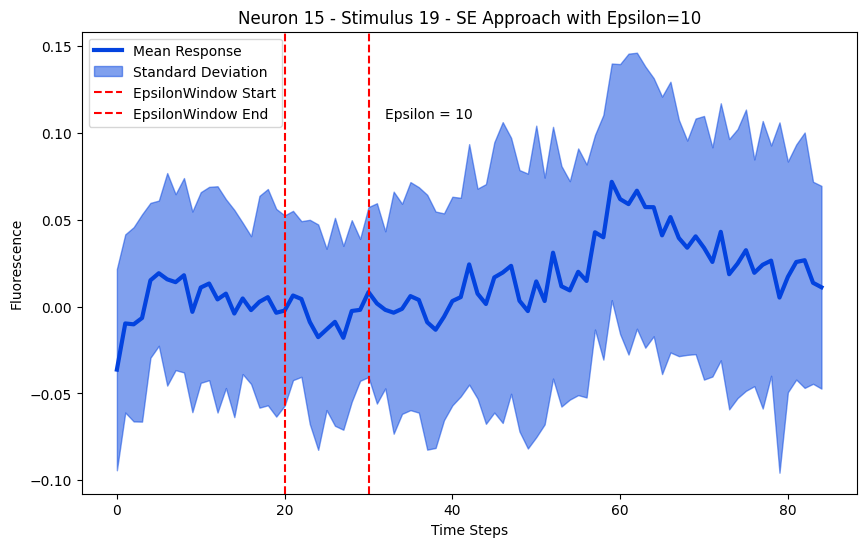

In [22]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mean_response, lw=3, color='xkcd:blue', label='Mean Response')
plt.fill_between(range(TRIAL_LEN), mean_response - std_error, mean_response + std_error, 
                 color='xkcd:blue', alpha=0.5, label='Standard Deviation')
plt.axvline(x=STIMULUS_START, color='r', linestyle='--', label='EpsilonWindow Start')
plt.axvline(x=STIMULUS_START + STIMULUS_WINDOW_SIZE, color='r', linestyle='--', label='EpsilonWindow End')
plt.annotate(f'Epsilon = {epsilon}', xy=(STIMULUS_START + STIMULUS_WINDOW_SIZE + 2, mean_response[STIMULUS_START + STIMULUS_WINDOW_SIZE] + 0.1))

plt.title(f'Neuron {example_neuron} - Stimulus {example_stimulus} - SE Approach with Epsilon={epsilon}')
plt.xlabel('Time Steps')
plt.ylabel('Fluorescence')
plt.legend()
plt.show()

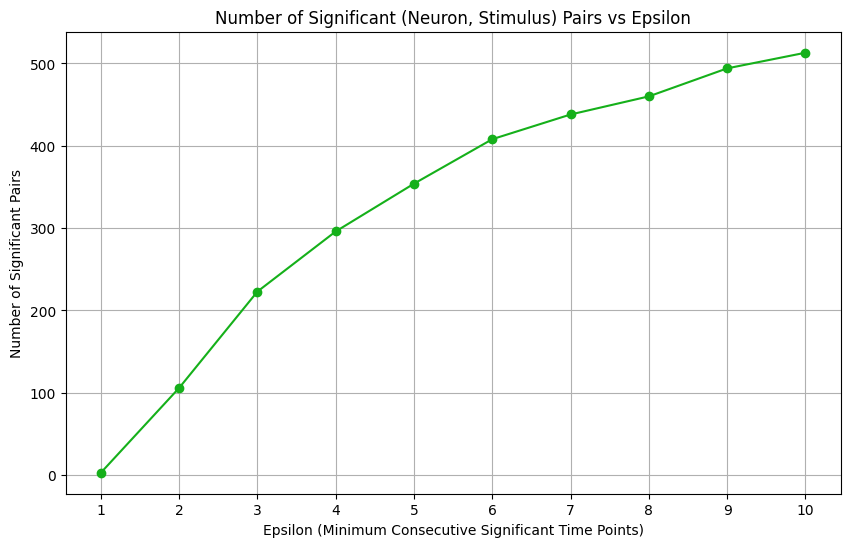

In [23]:
epsilon_counts = [len(significant_se_diff_dict[epsilon]) for epsilon in EPSILON_VALUES]

plt.figure(figsize=(10, 6))
plt.plot(EPSILON_VALUES, epsilon_counts, marker='o', linestyle='-', color='xkcd:green')
plt.title('Number of Significant (Neuron, Stimulus) Pairs vs Epsilon')
plt.xlabel('Epsilon (Minimum Consecutive Significant Time Points)')
plt.ylabel('Number of Significant Pairs')
plt.xticks(EPSILON_VALUES)
plt.grid(True)
plt.show()

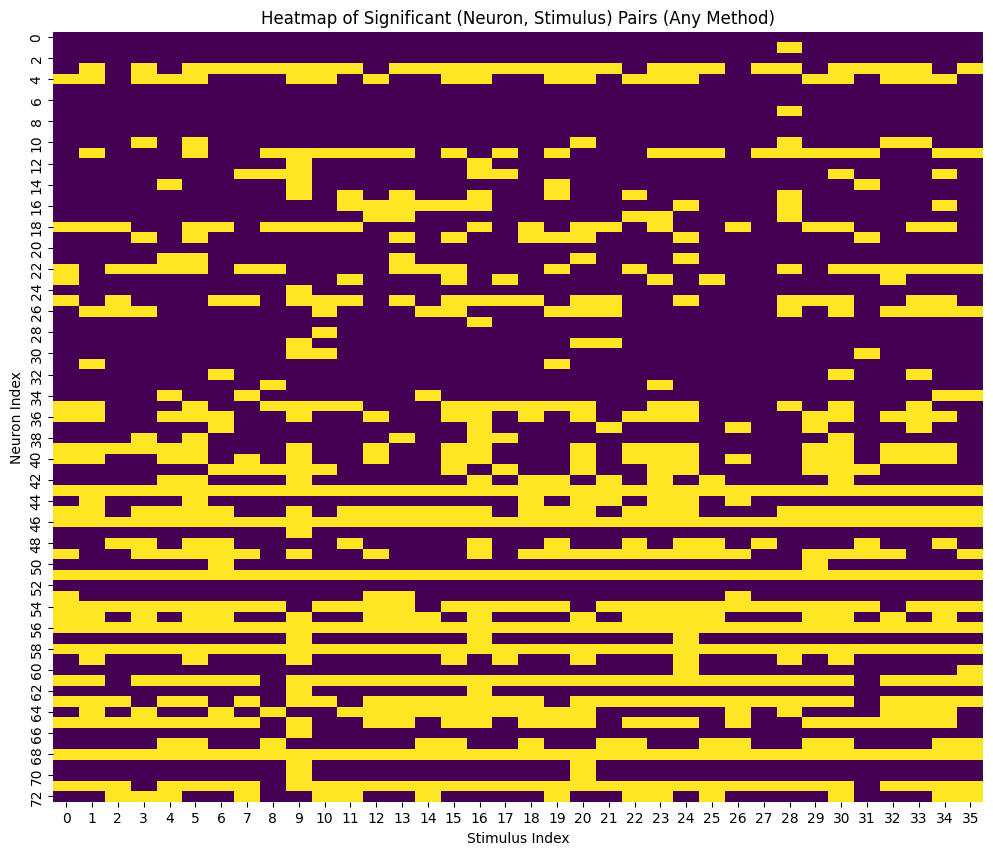

In [24]:
significant_any = set_mw.copy()
for epsilon in EPSILON_VALUES:
    significant_any.update(significant_se_diff_dict[epsilon])

heatmap_matrix = np.zeros((N_NEURONS, N_STIMS), dtype=int)
for (ni, si) in significant_any:
    heatmap_matrix[ni, si] = 1

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_matrix, cmap='viridis', cbar=False)
plt.title('Heatmap of Significant (Neuron, Stimulus) Pairs (Any Method)')
plt.xlabel('Stimulus Index')
plt.ylabel('Neuron Index')
plt.show()

### Tensor Decomposition

In [25]:
def normalize_tensor(data_tensor):
    """Normalizes the response tensor to prevent bias from high firing rates"""
    norm_data = np.zeros_like(data_tensor)
    for i in range(data_tensor.shape[0]):  # Iterate over neurons

        for j in range(data_tensor.shape[1]):  # Iterate over stimuli

            if(i,j) in significant_any:
                response = data_tensor[i, j]
                norm = np.linalg.norm(response)
                if norm > 0:
                    norm_data[i, j] = response / norm

    return norm_data

# Normalize the tensor using the significant pairs from Mann-Whitney U Test
X = normalize_tensor(X)

In [26]:
def reconstruct_tensor(factors):
    """Reconstructs the tensor from CP decomposition factors"""
    neurons, stimuli, time_len = factors[0].shape[0], factors[1].shape[0], factors[2].shape[0]
    rank = factors[0].shape[1]
    
    # Initialize reconstructed tensor
    reconstructed_tensor = np.zeros((neurons, stimuli, time_len))
    
    # Compute and sum the outer products of each rank-1 tensor
    for r in range(rank):
        component = np.outer(factors[0][:, r], factors[1][:, r])[:, :, np.newaxis] * factors[2][:, r]
        reconstructed_tensor += component
    
    return reconstructed_tensor

def run_cp_decomposition(data_tensor, rank, n_runs=15):
    """Runs CP decomposition multiple times for a given rank and returns reconstruction errors"""
    errors = []
    for _ in range(n_runs):
        result = tt.cp_als(data_tensor, rank=rank, verbose=False)
        # call reconstruct factors
        reconstruction = reconstruct_tensor(result.factors)
        # compute error
        error = np.linalg.norm(data_tensor - reconstruction) / np.linalg.norm(data_tensor)
        errors.append(error)
    return np.mean(errors), np.std(errors)


In [27]:
def find_optimal_rank(data_tensor, ranks, n_runs=15):
    """Runs CP decompositions for a range of ranks"""
    mean_errors = []
    std_errors = []
    
    for rank in ranks:
        mean_error, std_error = run_cp_decomposition(data_tensor, rank, n_runs)
        mean_errors.append(mean_error)
        std_errors.append(std_error)
        print(f"Rank {rank}: Mean Error = {mean_error:.4f}, Std. Dev = {std_error:.4f}")
    
    return np.array(mean_errors), np.array(std_errors)

def plot_errors(ranks, mean_errors, std_errors):
    """Plots the reconstruction error and variability as a function of rank"""
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot mean reconstruction with a solid line
    mean_line = ax1.plot(ranks, mean_errors, label="Mean Reconstruction Error", color="blue", marker='o', linestyle="-")
    
    ax1.set_xlabel("Number of Components (Rank)")
    ax1.set_ylabel("Mean Reconstruction Error", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    
    ax2 = ax1.twinx()
    
    # Plot standard deviation (variability) with a dashed line
    std_line = ax2.plot(ranks, std_errors, label="Error Variability (Std. Dev.)", color="gray", marker='s', linestyle="--")
    
    ax2.set_ylabel("Error Variability (Std. Dev.)", color="gray")
    ax2.tick_params(axis='y', labelcolor="gray")
    
    lines = mean_line + std_line
    labels = ["Mean Reconstruction Error", "Error Variability (Std. Dev.)"]
    ax1.legend(lines, labels, loc="upper right")
    
    plt.title("Selecting the Number of Tensor Components")
    fig.tight_layout()
    plt.show()


Rank 5: Mean Error = 0.5917, Std. Dev = 0.0001
Rank 6: Mean Error = 0.5772, Std. Dev = 0.0004
Rank 7: Mean Error = 0.5660, Std. Dev = 0.0006
Rank 8: Mean Error = 0.5551, Std. Dev = 0.0003
Rank 9: Mean Error = 0.5442, Std. Dev = 0.0004
Rank 10: Mean Error = 0.5337, Std. Dev = 0.0005
Rank 11: Mean Error = 0.5235, Std. Dev = 0.0004
Rank 12: Mean Error = 0.5144, Std. Dev = 0.0006
Rank 13: Mean Error = 0.5052, Std. Dev = 0.0004
Rank 14: Mean Error = 0.4971, Std. Dev = 0.0003
Rank 15: Mean Error = 0.4898, Std. Dev = 0.0005
Rank 16: Mean Error = 0.4826, Std. Dev = 0.0004
Rank 17: Mean Error = 0.4762, Std. Dev = 0.0006
Rank 18: Mean Error = 0.4697, Std. Dev = 0.0005
Rank 19: Mean Error = 0.4637, Std. Dev = 0.0005


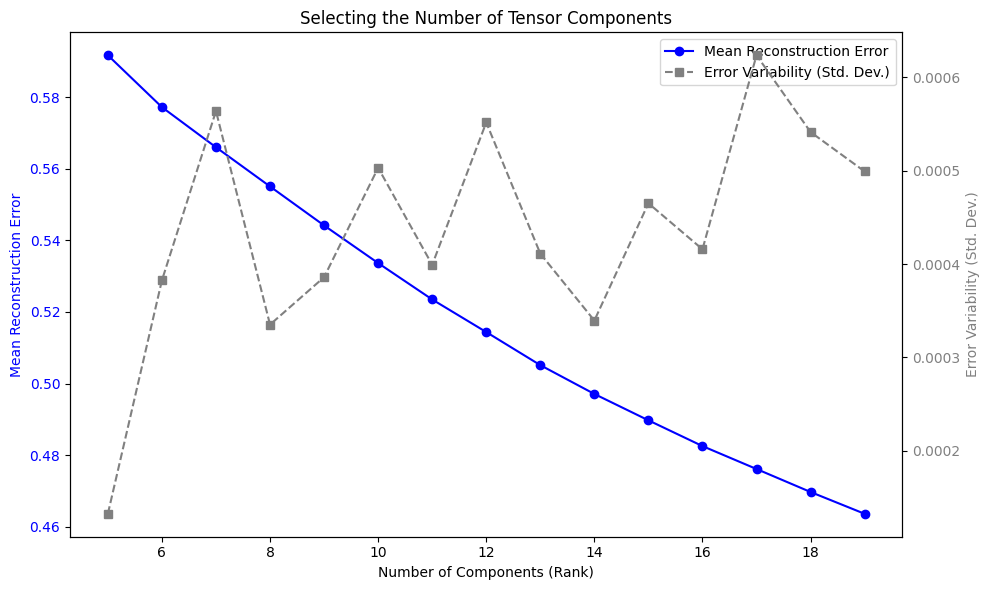

In [28]:
# Find Rank
ranks = range(5, 20)  # Define range of ranks to test
n_runs = 25  # Number of runs per rank

mean_errors, std_errors = find_optimal_rank(X, ranks, n_runs)
plot_errors(ranks, mean_errors, std_errors)

In [29]:
def plot_factor_matrices(factorization):
    """Plots the neuron, stimulus, and time factor matrices for each component."""
    factors = factorization.factors
    rank = factors[0].shape[1]  # Rank of decomposition
    
    fig, axes = plt.subplots(3, rank, figsize=(4 * rank, 12))
    
    for r in range(rank):
        # Neuron factor plot
        axes[0, r].plot(factors[0][:, r])
        axes[0, r].set_title(f"Component {r+1} - Neurons")
        
        # Stimulus factor plot
        axes[1, r].plot(factors[1][:, r])
        axes[1, r].set_title(f"Component {r+1} - Stimuli")
        
        # Time factor plot
        axes[2, r].plot(factors[2][:, r])
        axes[2, r].set_title(f"Component {r+1} - Time")
    
    axes[0, 0].set_ylabel("Neuron Factors")
    axes[1, 0].set_ylabel("Stimulus Factors")
    axes[2, 0].set_ylabel("Time Factors")
    
    plt.tight_layout()
    plt.show()

CP_ALS: iteration 1, objective 0.6760491834722366, improvement inf.
CP_ALS: iteration 2, objective 0.5424161411095254, improvement 0.13363304236271123.
CP_ALS: iteration 3, objective 0.5144786103899793, improvement 0.027937530719546078.
CP_ALS: iteration 4, objective 0.5078710517182733, improvement 0.0066075586717060375.
CP_ALS: iteration 5, objective 0.5052062337126301, improvement 0.0026648180056432214.
CP_ALS: iteration 6, objective 0.503723954489455, improvement 0.0014822792231751203.
CP_ALS: iteration 7, objective 0.5027382513972675, improvement 0.0009857030921874843.
CP_ALS: iteration 8, objective 0.5020041879389212, improvement 0.0007340634583462569.
CP_ALS: iteration 9, objective 0.5014100849798888, improvement 0.0005941029590323943.
CP_ALS: iteration 10, objective 0.5008983785794332, improvement 0.0005117064004556138.
CP_ALS: iteration 11, objective 0.5004373607957279, improvement 0.00046101778370533086.
CP_ALS: iteration 12, objective 0.5000091663497569, improvement 0.0004281

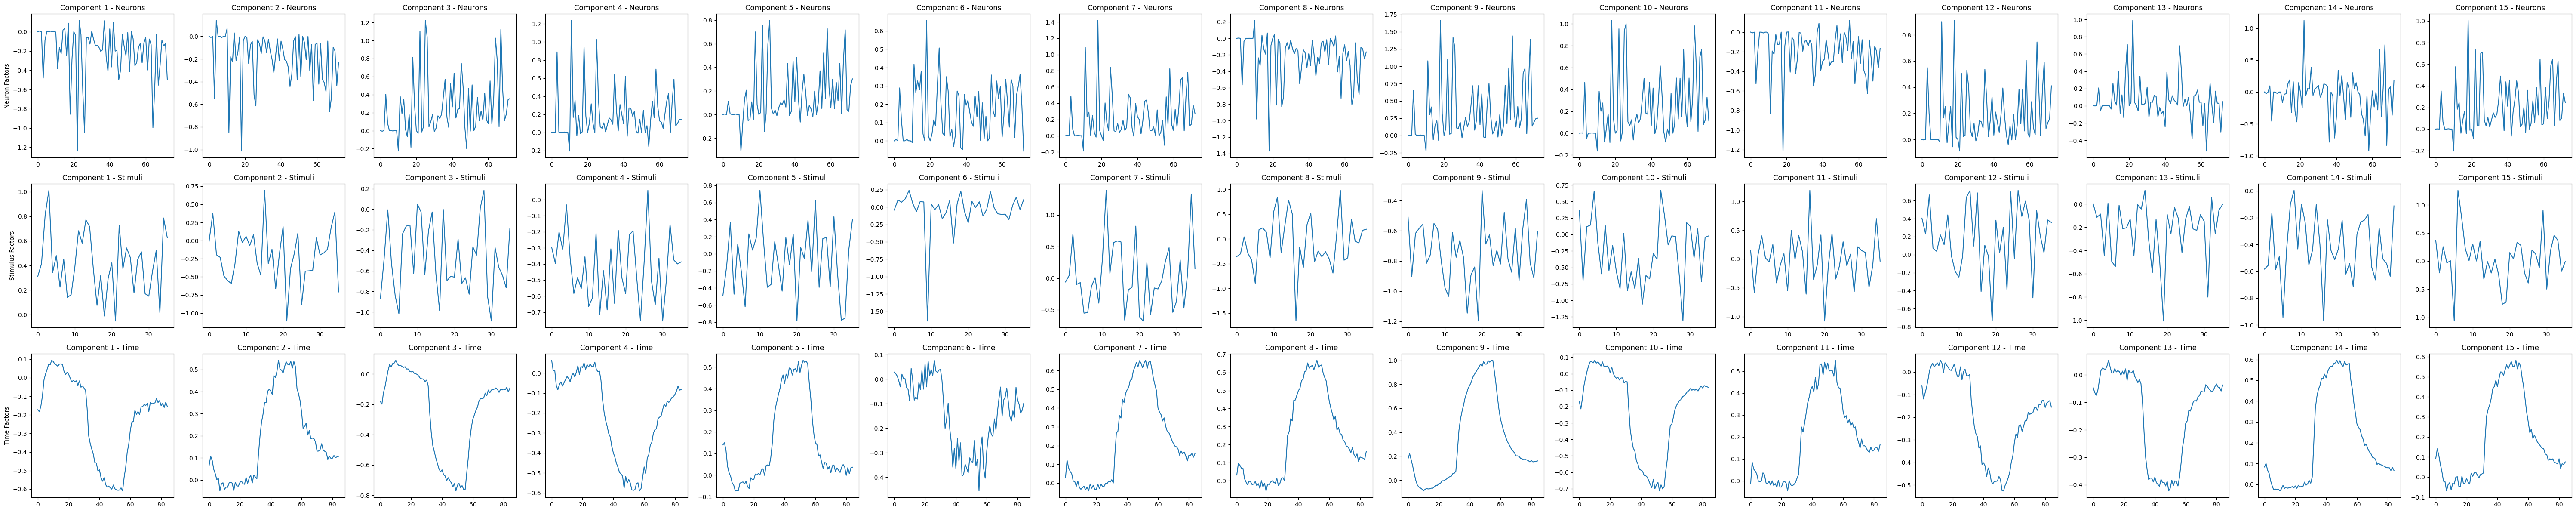

In [30]:
# Choose Optimal Rank from Plots
optimal_rank = 15

# Compute CP Decomposition
optimal_factorization = tt.cp_als(X, rank=optimal_rank, verbose=True)
plot_factor_matrices(optimal_factorization)

In [31]:
optimal_factorization.factors[0].shape, optimal_factorization.factors[1].shape, optimal_factorization.factors[2].shape

((73, 15), (36, 15), (85, 15))

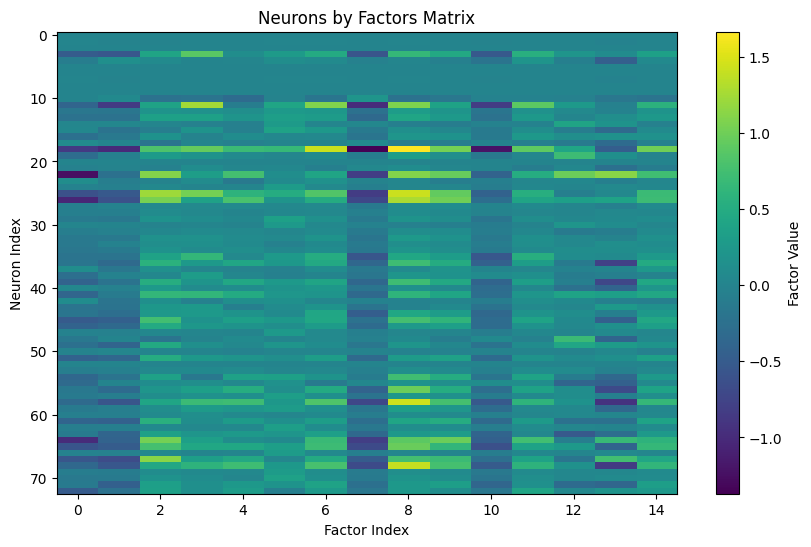

In [32]:
# constuct neurons by factors matrix from the optimal factorization
neurons_by_factors = np.zeros((N_NEURONS, optimal_rank))
neurons_by_factors = optimal_factorization.factors[0]

# plot the neurons by factors matrix
plt.figure(figsize=(10, 6))
plt.imshow(neurons_by_factors, aspect='auto', cmap='viridis')
plt.title('Neurons by Factors Matrix')
plt.xlabel('Factor Index')
plt.ylabel('Neuron Index')
plt.colorbar(label='Factor Value')
plt.show()

### Preliminary Manifold

In [55]:
from ian.ian import * 
from ian.embed_utils import *
from ian.dset_utils import *
from ian.utils import *

In [59]:
def remove_duplicates(data):
    """Removes duplicate rows from a numpy array"""
    return np.unique(data, axis=0)

neurons_by_factors_unique = remove_duplicates(neurons_by_factors)
print(neurons_by_factors.shape)
print(neurons_by_factors_unique.shape)

(73, 15)
(66, 15)


In [60]:
D2 = pwdists(neurons_by_factors_unique, sqdists=True)

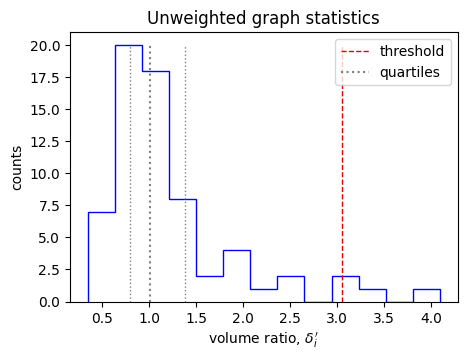

### Iteration 1 done. (0.10 s) - pruned 1 edge(s)
### Iteration 2 done. (0.01 s) - pruned 1 edge(s)


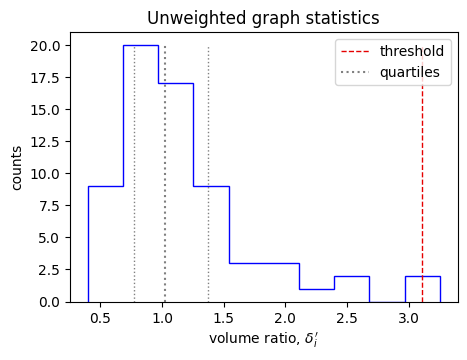

### Iteration 3 done. (0.06 s) - pruned 1 edge(s)
CONVERGED: no change in unweighted graph.
Total # edges pruned: 3, (0 disconnected points)
C-tuning weighted graph...
Unweighted graph stats: mean=1.168, median=1.023
Weighted graph stats: mean=1.104, median=0.965


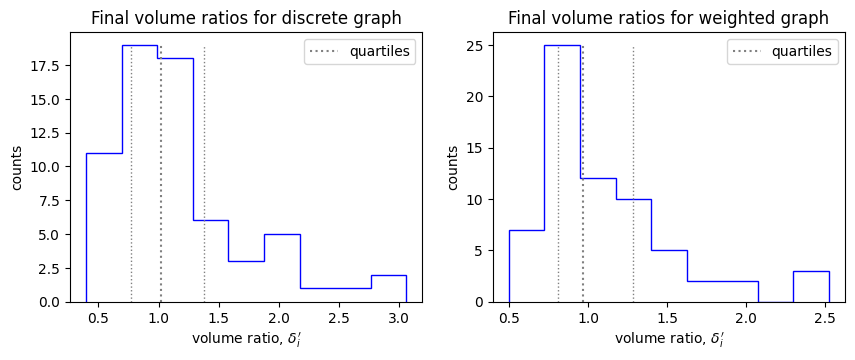

In [61]:
G, wG, optScales, disc_pts = IAN('exact-precomputed-sq', D2, plot_interval=2)


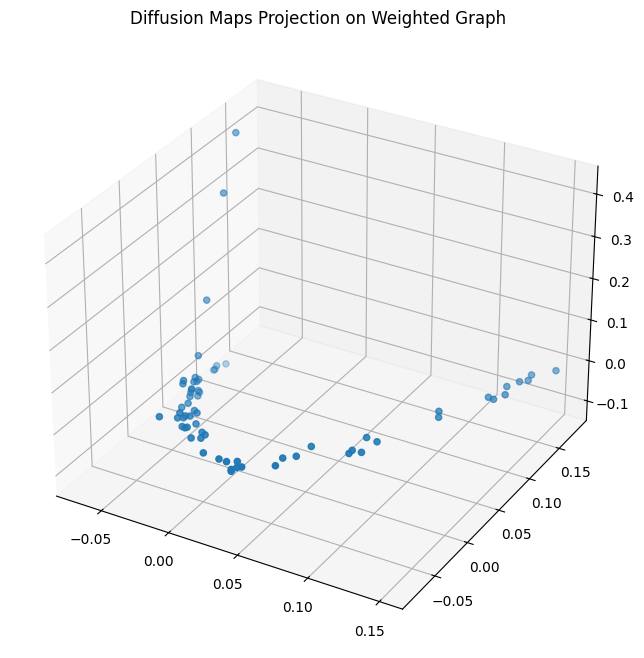

In [62]:
diffusion = SpectralEmbedding(n_components=3, affinity='precomputed')
embedding = diffusion.fit_transform(wG)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax.set_title('Diffusion Maps Projection on Weighted Graph')
plt.show()


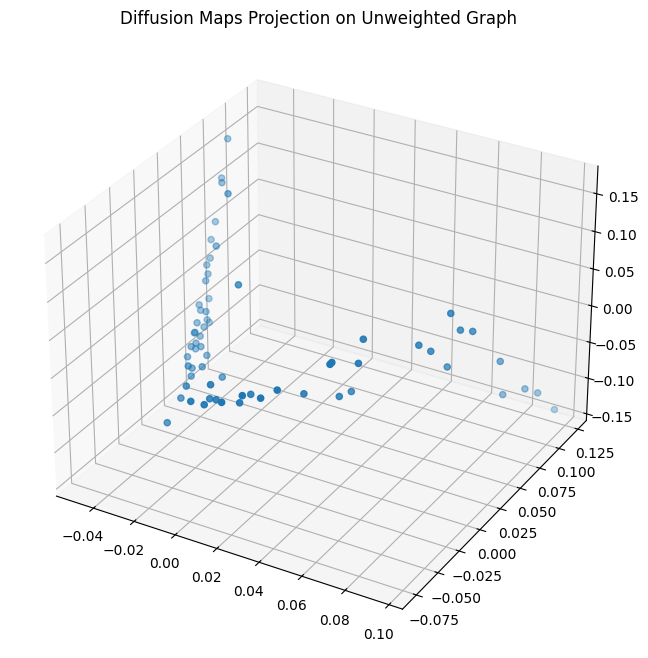

In [63]:
diffusion = SpectralEmbedding(n_components=3, affinity='precomputed')
embedding = diffusion.fit_transform(G)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax.set_title('Diffusion Maps Projection on Unweighted Graph')
plt.show()

### Response Maps

In [64]:
gratings_ixs = [19, 6, 31, 11]  # Indices for directions: 0°, 90°, 180°, 270°
grating_directions = ['0°', '90°', '180°', '270°']

def smooth_trace(trace, window_size=3):
    return np.convolve(trace, np.ones(window_size)/window_size, mode='same')
    
X_gratings = X[:, gratings_ixs, :]  # select 4 grating directions
print(f"X_gratings shape: {X_gratings.shape}")  # Expect: (73, 4, 85)


X_gratings shape: (73, 4, 85)


In [77]:
def plot_neuron_response_map(data_tensor, neuron_idx, directions, direction_labels, smooth=False, window_size=3):
    """
    Plots a single response map (heatmap) for a given neuron across all specified directions.
    """
    # Shape: (N_DIRECTIONS, TRIAL_LEN)
    responses = data_tensor[neuron_idx, directions, :]  
    
    if smooth:
        responses = np.array([smooth_trace(trace, window_size) for trace in responses])
    
    plt.figure(figsize=(15, 6))
    
    sns.heatmap(responses, 
                cmap='hot', 
                xticklabels=np.arange(responses.shape[1])[::10],  # Label every 10 time steps
                yticklabels=direction_labels, 
                cbar_kws={'label': 'Mean dF/F'})
    
    plt.title(f'Neuron {neuron_idx} - Response Map for Grating Directions', fontsize=16)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Grating Direction', fontsize=14)
    
    plt.tight_layout()
    plt.show()

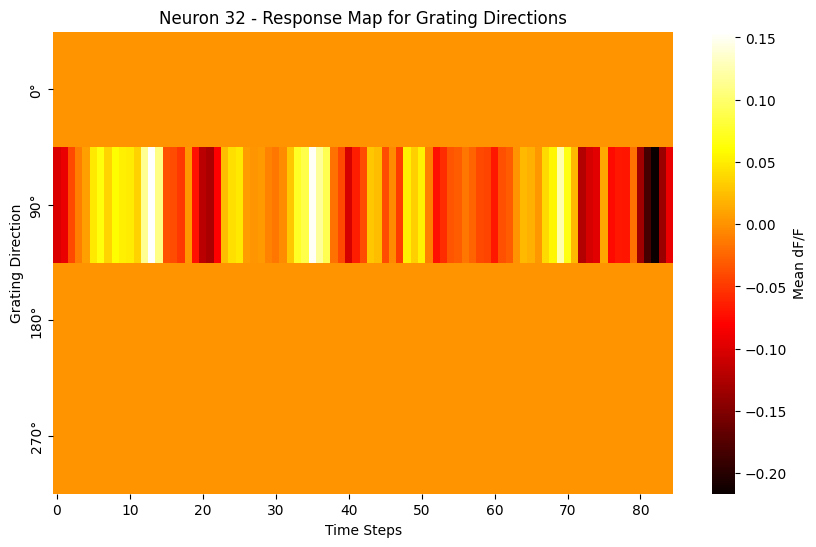

In [100]:
neuron_list = [32]

for neuron in neuron_list:
    plot_neuron_response_map(data_tensor=X_gratings, 
                             neuron_idx=neuron, 
                             directions=gratings_ixs, 
                             direction_labels=grating_directions, 
                             smooth=True, 
                             window_size=3)

# %%

In [103]:
def plot_multiple_neurons_response_maps(data_tensor, neuron_indices, direction_labels, 
                                        smooth=False, window_size=3, ncols=3, figsize=(15, 10)):
    """
    Plots multiple response maps (heatmaps) for specified neurons across all directions in a single figure.
    """
    n_neurons = len(neuron_indices)
    nrows = int(np.ceil(n_neurons / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    all_responses = []
    for neuron_idx in neuron_indices:
        responses = data_tensor[neuron_idx, :, :]  # Shape: (4, 85)
        if smooth:
            responses = np.array([smooth_trace(trace, window_size) for trace in responses])
        all_responses.append(responses)
    all_responses = np.array(all_responses)
    vmin = all_responses.min()
    vmax = all_responses.max()
    
    for idx, neuron_idx in enumerate(neuron_indices):
        ax = axes[idx]
        
        # Extract responses for the specified neuron and directions
        responses = data_tensor[neuron_idx, :, :]  # Shape: (4, TRIAL_LEN)
        
        if smooth:
            responses = np.array([smooth_trace(trace, window_size) for trace in responses])
        
        im = ax.imshow(responses, aspect='auto', cmap='hot', vmin=vmin, vmax=vmax)
        ax.set_xlabel('Time Steps', fontsize=10)
        ax.set_ylabel('Grating Direction', fontsize=10)
        ax.set_yticks(np.arange(len(direction_labels)))
        ax.set_yticklabels(direction_labels)
        ax.set_title(f'Neuron {neuron_idx}', fontsize=12)
    
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.tight_layout()
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Mean dF/F', fontsize=12)
    
    fig.suptitle('Neurons Response Maps for Grating Directions', fontsize=16, y=1.02)
    plt.show()

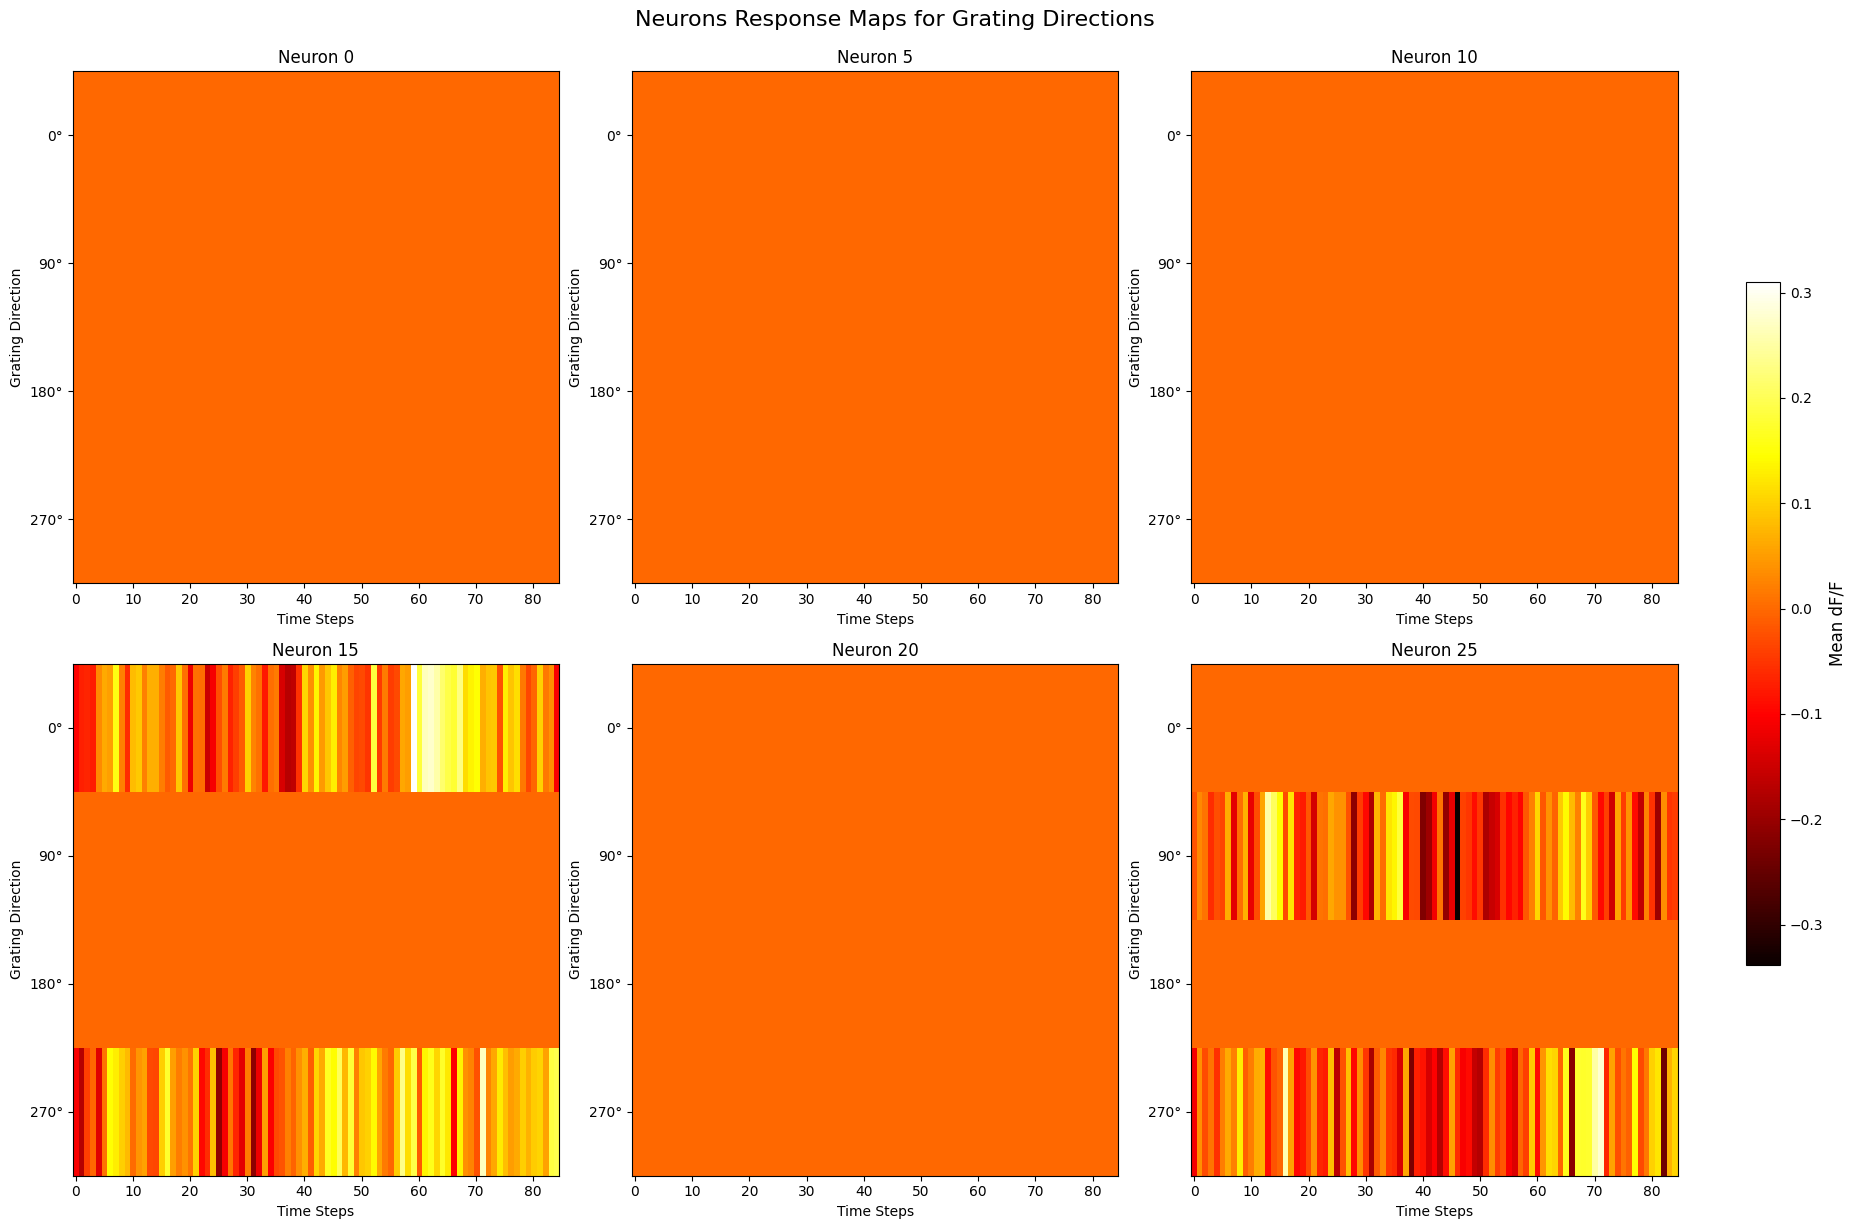

In [104]:
selected_neurons = [0, 5, 10, 15, 20, 25]

plot_multiple_neurons_response_maps(
    data_tensor=X_gratings, 
    neuron_indices=selected_neurons, 
    direction_labels=grating_directions, 
    smooth=False, 
    window_size=3, 
    ncols=3, 
    figsize=(18, 12)
)